# Completing datas before cleaning 
### By PHO, MBF, SIH and MAU (english is not our primary language, so our best apologies for any eyes bleeding due to reading this notebook)

As it has already been signified in [covid-19-literature-clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering) for example, the available dataset contains duplicates and missing data. Numerous Kernels proposed to clean the available metadata, notably by deleting those duplicates or/and incomplete data [covid-19-literature-clustering](https://www.kaggle.com/maksimeren/covid-19-literature-clustering), [eda-preprocessing-cleaning-cord-19-metadata](https://www.kaggle.com/kdu4108/eda-preprocessing-cleaning-cord-19-metadata) and [clean-metadata-file](https://www.kaggle.com/mikehoney/clean-metadata-file).

If some proposes way to enrich the available data (see Zac Danelly’s works for example [Discussion/14068](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/140678) or this one from Andy White [discussion/140597](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/140597)), few, to our knowledge, seek to complete the missing texts and abstracts like Savanna Reid suggested it in [discussion/138421](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/138421). However, such an approach would be undeniably positive concerning the amount of data usable by our algorithms. Moreover, for our main work, the paragraph segmentation of the abstracts and the text is really important. Unfortunately, this segmentation is not present in the metadata CSV given in this challenge. Therefore, we decided that the first step of our approach would be to use the data provided by various APIs (we used [https://europepmc.org/RestfulWebService](https://europepmc.org/RestfulWebService) and [https://www.ncbi.nlm.nih.gov/books/NBK25500/](https://www.ncbi.nlm.nih.gov/books/NBK25500/) in this notebook) in order to complete the available dataset. We would have obviously better results with better API (like springer or eslevier). 

The results of [donkeys/languages](https://www.kaggle.com/donkeys/languages) shows that there are various languages available (mostly English). [discussion/139231](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139231) proposed to use various tools to translate automatically languages to English, but we decided against it, having no guarantee of the results. Once the data has been completed with the APIs, we clean the remaining duplicates or missing data and drop also the non-English papers. 

- The first part of this notebook is about exploring, augmenting (by requesting API) the given COVID-19 dataset.
- The second part is about cleaning the text

# Ranking papers based on their Keyphrases 

People have tried to fulfill the various tasks (or help other fulfill them) in this Kaggle in quite a lot of ways. Some created search engines ([jdparsons/biobert-corex-topic-search](https://www.kaggle.com/jdparsons/biobert-corex-topic-search/notebook), [discussion/138026](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/138026)), some proposed tools ([ajrwhite/covid19-tools](https://www.kaggle.com/ajrwhite/covid19-tools/notebook), [discussion/138250](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/138250), [discussion/139106](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139106)), some used knowledge graphs ([group16/covid-19-knowledge-graph-embeddings](https://www.kaggle.com/group16/covid-19-knowledge-graph-embeddings), [sandyvarma/covid-19-bert-mesh-enabled-knowledge-graph](https://www.kaggle.com/sandyvarma/covid-19-bert-mesh-enabled-knowledge-graph)), some used KeyPhrases [hamid3731/keyphrase-extraction-and-graph-analysis](https://www.kaggle.com/hamid3731/keyphrase-extraction-and-graph-analysis), etc.  

On our end, we decided that the way we would try to fulfill the various tasks would be to propose a way to rank the various papers between themselves. Some already have proposed scoring functions like [discussion/140726](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/140726). Some like [discussion/137558](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/137558) proposed to base our ranking on the study design (with this discussion [discussion/139355](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139355) directly linked to it). 

At the moment, to rank our papers, we decided to use a technique similar to TextRank (used in [shahules/cord-tools-and-knowledge-graphs](https://www.kaggle.com/shahules/cord-tools-and-knowledge-graphs) or [mobassir/mining-covid-19-scientific-papers](https://www.kaggle.com/mobassir/mining-covid-19-scientific-papers/notebook) for example). But contrary to the work of [21] who uses TextRank on sentences for automatic summarization, we use our ranking method to extract the most relevant KeyPhrases from a paper and then rank the papers between each other.  

- The third part of this notebook is about Ranking important sentences and documents using extracted keyphrases (keywords).

## Why to use keyphrases?

**Keyphrases** (also keywords or keyterms) are the most representative segments of text within the body of a document. **Extracted keyphrases** can be used in extactive summarization, using keyphrases to rank chunks of text. This approach can be used to rank  sentences and documents helping to recover important information.

### Motivation: 

*TextRank* is a graph-based ranking model for unsupervised automatic keyphrase extraction. In the paper [TextRank: Bringing Order into Text](https://www.aclweb.org/anthology/W04-3252/), it is proposed as an useful method for extractive summarization, since it produces ranked keyphrases. An implementation of this method is available for [Spacy](https://spacy.io/) in the universe modules [pyTextRank](https://spacy.io/universe/project/spacy-pytextrank). However, as mentioned in the challenge kernel [KeyPhrase Extraction and Graph analysis](https://www.kaggle.com/hamid3731/keyphrase-extraction-and-graph-analysis), TextRank is not the best available method. 

Instead of using TexkRank to extract keyphrases, we propose to use a supervised CRF-based method that *filters candidates of keyphrases* using their *PoS tag sequences* [**LIPN** at SemEval 2017 Task 10](https://www.aclweb.org/anthology/S17-2174/). Several members of our team participating in the current Kaggle challenge are former integrants of the LIPN team who presented that work. 

We used an improved version of the method available in the python package [kleis](https://pypi.org/project/kleis-keyphrase-extraction/). The latest version of this package achieves a **F1 score of 0.405 (40.5%)** on the dataset *SemEval 2017 Task 10* for the subtask of keyphrase identification. 

### To consider about *kleis*:

    - It is a non-rank based method to extract keyphrases
    - It is a supervised method
    - It is not trained over medical data

### Our approach

We ranked documents and sentences using keyphrases from a supervised non-rank based method to extract keyphrases. 

Current work:

    - Keyphrases are weighted using tf-idf
    - Sentences are ranked using the weighted keyphrases
    - Documents are ranked using the ranks of the sentences

ToDo:

    - Improve documents' rank using similarity between keyphrases
    - Find synonyms to improve document retrieval
    - Train kleis over medical data

### Example 

The example shows a ranked document and its ranked sentences. In green are shown the extracted keyphrases using *kleis*.

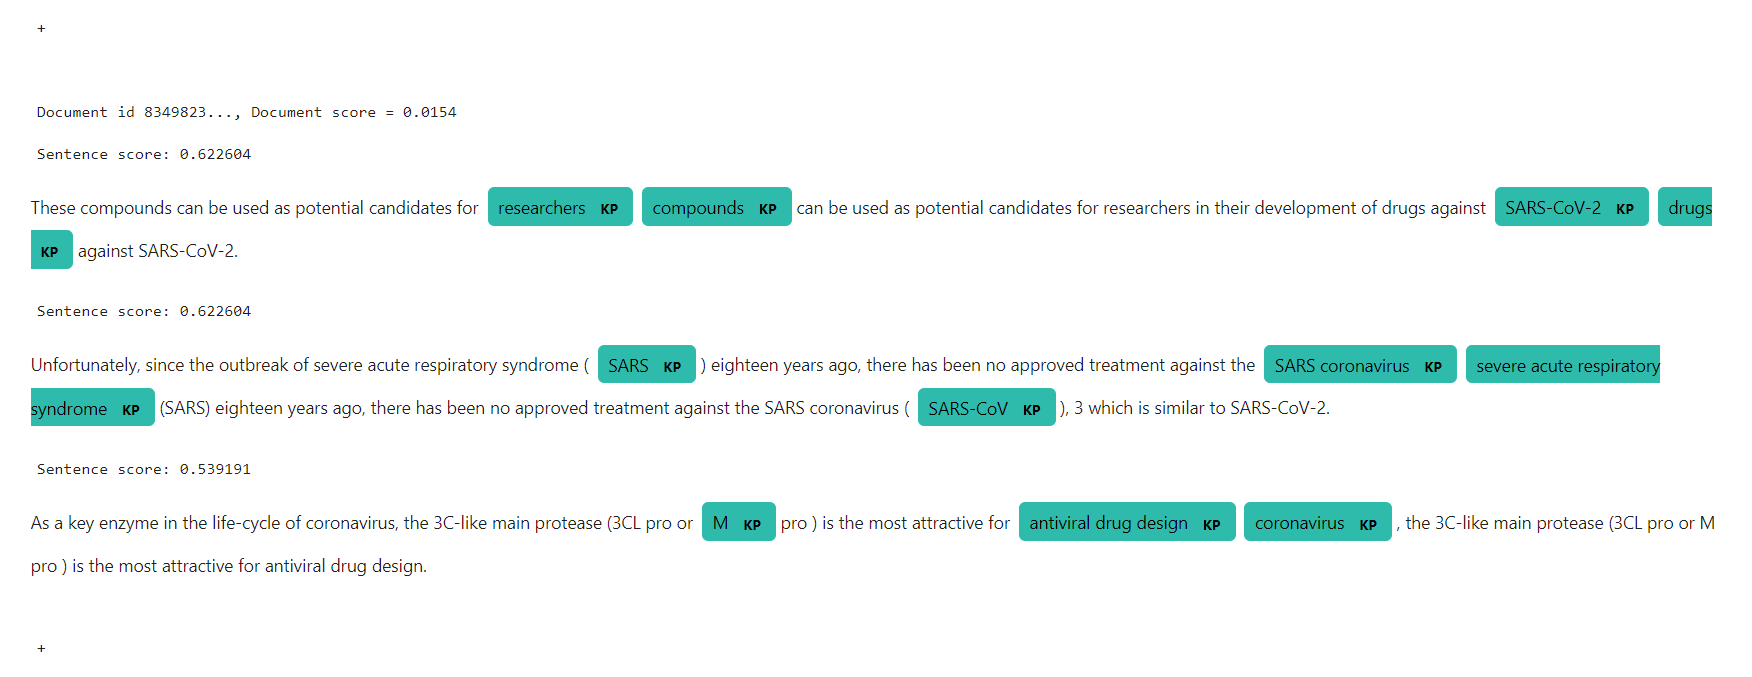

# Part 1 - Exploring and Augmenting

In [ ]:
import os
import re
import gc
import sys
import time
import math
import glob
import json
import spacy
import pandas
import random
import pickle
import pprint
import requests
import numpy as np
import cufflinks as cf

from pathlib import Path
from spacy import displacy
from tqdm.notebook import tqdm
from collections import Counter 
from collections import defaultdict
from nltk.corpus import stopwords
from gensim.utils import lemmatize
from IPython.core.display import HTML, Markdown

import xml.etree.ElementTree
from json import JSONDecodeError
from urllib.error import HTTPError
from xml.etree.ElementTree import ParseError

import warnings
warnings.filterwarnings('ignore')

# defining some options for displacy
colors = {"KP": "#2fbbab"}
options = {"ents": ["KP"], "colors": colors}

# defining some options for pandas
pandas.set_option('display.max_rows', 5)
pandas.set_option('display.max_columns', None)

# defining some options for cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Let's look at the data (version 6)
- there is a lot of missing data in each column, we forced the type of some column to avoir parsing errors later
- new in v6 there is a json file from XML parse and PDF parse.
- that's actually a really good thing, because we found a lot of PDF parsing errors in the dataset :
### Let's show an example :
- we have to load the metadata and the json first

In [ ]:
v6_path = '/kaggle/input/CORD-19-research-challenge'
df = pandas.read_csv(f'{v6_path}/metadata.csv', dtype={
    'sha': str,
    'abstract': str,
    'body_text': object,
    'title': str,
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'WHO #Covidence': str,
    'pmcid': str,
    'doi': str,
    'url': str
}, keep_default_na=False)

- we made a dictionnary of the path of each file
- "sha" as key for the papers from PDF parsing
- "pmcid" as key for the papers from XML parsing

In [ ]:
pdf_json_dict = dict()
for filename in tqdm(glob.glob(f'{v6_path}/**/pdf_json/*.json', recursive=True), leave = False): 
    pdf_json_dict[json.load(open(filename, 'rb'))['paper_id']] = filename
print(len(pdf_json_dict), "papers from PDF parsing")

xml_json_dict = dict()
for filename in tqdm(glob.glob(f'{v6_path}/**/pmc_json/*.json', recursive=True), leave = False): 
    xml_json_dict[json.load(open(filename, 'rb'))['paper_id']] = filename
print(len(xml_json_dict), "papers from XML parsing")

- Back to the example, according to the metadata, the title of the paper with PMCID PMC261871 is :

In [ ]:
df.loc[df.index[df["pmcid"] == "PMC261871"], ['sha', 'doi', 'title']]

- But, according to the PDF json file, it's title is :

In [ ]:
print(json.load(open(pdf_json_dict["941a9a3f0138f7c01ff930023a4aa428a18170e1"], 'rb'))['metadata']['title'])

- After looking into thoses issues, we found that it's a parsing error from the pdf of the paper :

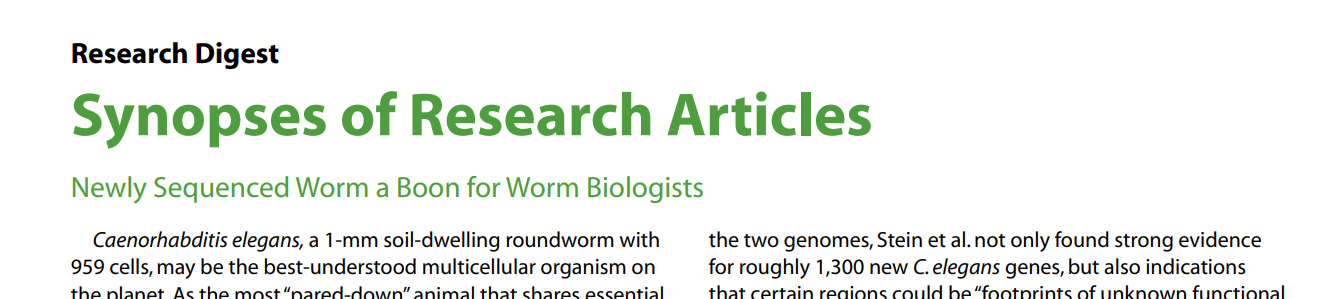

- According to its DOI, The real name of the paper is supposed to be :

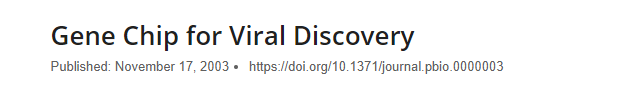

## And there is a lot of this king of PDF parsing error in the data.
### Thanks to the v6 update of the data, some are already easily fixable
- We can now use the XML json to get more confident data

In [ ]:
print(json.load(open(xml_json_dict["PMC261871"], 'rb'))['metadata']['title'])

### But the v6 can still be improved
- Indeed, there is no abstract in the XML file, maybe a mistake according to the given JSON schema, but probably because it's already merge in the metadata

In [ ]:
print(np.sum([1 if "abstract" in json.load(open(xml_json_dict[key], 'rb')) else 0 for key in tqdm(xml_json_dict, leave = False)]), " abstracts in the XML file")
print(np.sum([1 if "body_text" in json.load(open(xml_json_dict[key], 'rb')) else 0 for key in tqdm(xml_json_dict, leave = False)])," body_text in the XML file")
print(np.sum([1 if ("abstract" in json.load(open(pdf_json_dict[key], 'rb')) and json.load(open(pdf_json_dict[key], 'rb'))["abstract"] != []) else 0 for key in tqdm(pdf_json_dict, leave = False)]), " non empty abstracts in the PDF file")
print(np.sum([1 if ("body_text" in json.load(open(pdf_json_dict[key], 'rb')) and json.load(open(pdf_json_dict[key], 'rb'))["body_text"] != []) else 0 for key in tqdm(pdf_json_dict, leave = False)]), " non empty body_text in the PDF file")

### So we lost the valuable paragraph segmentation from the sources 
- We need this segmentation, like in the example below, to be able to rank the best paragraph :

In [ ]:
display(json.load(open(pdf_json_dict["a92e70c0a129a56173ef38bf186c1cd7ecfe6d9f"], 'rb'))['abstract'])

### Moreover, 19 062 fulltext are based only on PDF parse with no confidence on the quality of the data :

In [ ]:
print("For the",len(df), "papers in the dataset (v6)")
print("-", len(df[df["has_pdf_parse"]]), "papers with PDF parse")
print("-", len(df[df["has_pmc_xml_parse"]]), "papers with XML parse")
print("-", len(df[(df["has_pdf_parse"]) & (df["has_pmc_xml_parse"] == False) ]), "papers with PDF parse but no XML parse")

### And there is also a lot of missing data in the dataset :

In [ ]:
print("For the",len(df), "papers in the dataset (v6)")
print("-", len(df[df["title"] == ""]), "papers without title")
print("-", len(df[df["abstract"] == ""]), "papers without abstract")
print("-", len(df[df["full_text_file"] == ""]), "papers without fulltext")

### But there is a lot of crossref references in the metadata

In [ ]:
print(len(df[ (df['full_text_file'] == "") & (df['pmcid'] != "") ]), "papers without fulltext but a PMC ID as a reference")
print(len(df[ (df['full_text_file'] == "") & (df['doi'] != "") ]), "papers without fulltext but a DOI as a reference")
print(len(df[ (df['full_text_file'] == "") & (df['Microsoft Academic Paper ID'] != "") ]), "papers without fulltext but a Microsoft Academic Paper ID as a reference")
print(len(df[ (df['full_text_file'] == "") & (df['WHO #Covidence'] != "") ]), "papers without fulltext but a WHO #Covidence as a reference")
print(len(df[ (df['full_text_file'] == "") & (df['pubmed_id'] != "") ]), "papers without fulltext but a Pubmed id as a reference")

### We could use some Open Data Rest API to get some of the missing data and correct some PDF parsing errors
### First, let's merge the data from the metadata and from the json files
- So we used the metadata file as the source and we augmented it with all the json data ;
- For the body text, due to the PDF parsing errors, we prioritized the xml json over the pdf json;
- For the abstract, since the is no abstract in the xml json, we used the pdf json;

In [ ]:
tqdm.pandas()
df["sha"] = df["sha"] = df["sha"].apply(lambda x: x.split("; ")[0])
df["abstract_f"] = df["sha"].progress_apply(lambda x : json.load(open(pdf_json_dict[x], 'rb'))['abstract'] if x in pdf_json_dict else [] )

In [ ]:
df["body_text"] = df["cord_uid"].apply(lambda x : [])
for index, meta_data in tqdm(df.iterrows(), total = len(df.index)) :
    if meta_data["sha"] != "" and meta_data["sha"] in pdf_json_dict :
        file = json.load(open(pdf_json_dict[meta_data["sha"]], 'rb'))
        if(file['body_text'] != []) :
            df.at[(df[df['sha'] == meta_data["sha"]].index)[0], 'body_text'] = file['body_text']
        
    if meta_data["pmcid"] != "" and meta_data["pmcid"] in xml_json_dict :
        file = json.load(open(xml_json_dict[meta_data["pmcid"]], 'rb'))
        if(file['body_text'] != []) :
            df.at[(df[df['pmcid'] == meta_data["pmcid"]].index)[0], 'body_text'] = file['body_text']  

- We don't need the json dict anymore, so let's empty the limited RAM

In [ ]:
del pdf_json_dict
del xml_json_dict
gc.collect()

- The example below shows that we got back the paragraph segmentation dropped in the kaggle given v6 metadata

In [ ]:
pandas.set_option('display.max_colwidth', -1)
display(df.loc[df[df["pmcid"] == "PMC7106123"].index, ['title', 'title_f', 'abstract', 'abstract_f']])
pandas.set_option('display.max_colwidth', 50)

### So Let's see our data now :

In [ ]:
print("For the",len(df), "papers in the dataset (v6)")
print("-", len(df[df["abstract"] != ""]), "papers with one string abstract")
print("-", len(df[df["abstract_f"].apply(lambda x: x != [])]), "papers with paragraph segmented abstract")
print("-", len(df[df["body_text"].apply(lambda x: x != [])]), "papers with fulltext")

### From an other point of view, what are we still missing :

In [ ]:
print(len(df[(df['body_text'].apply(lambda x: x == [])) ]), "papers without fulltext")
print(len(df[(df['abstract_f'].apply(lambda x: x == []))]), "papers without paragraph segmented abstract")
print(len(df[(df['abstract_f'].apply(lambda x: x == [])) & (df['abstract'] == "") ]), "papers without abstract of any kind")
print(len(df[(df['body_text'].apply(lambda x: x == [])) & ((df['abstract_f'].apply(lambda x: x == [])) & (df['abstract'] == "")) ]), "papers without fulltext or abstract of any kind")

### Let's see if we can't get more data thanks to the precious data of the metadata file.

In [ ]:
print(len(df[ (df['body_text'].apply(lambda x: x == [])) & (df['pmcid'] != "") ]), "papers without fulltext but a PMC ID as a reference")
print(len(df[ (df['body_text'].apply(lambda x: x == [])) & (df['doi'] != "") ]), "papers without fulltext but a DOI as a reference")
print(len(df[ (df['body_text'].apply(lambda x: x == [])) & (df['Microsoft Academic Paper ID'] != "") ]), "papers without fulltext but a Microsoft Academic Paper ID as a reference")
print(len(df[ (df['body_text'].apply(lambda x: x == [])) & (df['WHO #Covidence'] != "") ]), "papers without fulltext but a WHO #Covidence as a reference")
print(len(df[ (df['body_text'].apply(lambda x: x == [])) & (df['pubmed_id'] != "") ]), "papers without fulltext but a Pubmed id as a reference")

# The use of some API could fix the PDF parsing error and fill the missing data:
### EUROPEPMC API (https://europepmc.org/RestfulWebService)
- We looked for the title, abstract and body_text ;
- It took some time to request that much paper ;
- We saved each content in a dictionnary with the paper ID as a key for later use ;

In [ ]:
pmc_empty_papers = df[ ((df['body_text'].apply(lambda x: x == [])) | (df['abstract_f'].apply(lambda x: x == []))) & (df['pmcid'] != "")]["pmcid"].tolist()
print(len(pmc_empty_papers))
print(pmc_empty_papers[:10])

In [ ]:
def api_call() :
    dict_europepmc = {}
    for paper_id in tqdm(pmc_papers) :
        try :
            response = requests.get("https://www.ebi.ac.uk/europepmc/webservices/rest/"+str(paper_id)+"/fullTextXML")
        except HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
        except Exception as err:
            print(f"An error ocurred: {err}")
    dict_europepmc[paper_id] = response.content
    #pickle.dump(dict_europepmc, open("dict_europepmc.pickle", "wb" ) )

In [ ]:
dict_europepmc = pickle.load(open("/kaggle/input/cord19-api-call/dict_europepmc.pickle", 'rb'))
display(len(dict_europepmc))

In [ ]:
print(len(df[ ((df['body_text'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without fulltext but with a PMCID")
print(len(df[ ((df['abstract_f'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without (paragraph segmented) abstract but with a PMCID")
print(len(df[ ((df['title'] == "") & (df['pmcid'] != "")) ]), "articles without title but with a PMCID")
cpt_record = 0
for paper_id in tqdm(pmc_empty_papers) :
    try :
        root = xml.etree.ElementTree.fromstring(dict_europepmc[paper_id])
        cpt_record = cpt_record + 1

        abstract = []
        for child in root.iter('abstract'):
            if "".join(child.itertext()) != "" : 
                abstract.append({'text': "".join(child.itertext()) }) 
                
        body_text = []
        for child in root.iter('body'):
            for p in child.iter("p"):
                if "".join(p.itertext()) != "" : 
                    body_text.append({'text': "".join(p.itertext()), 'cite_spans': [], 'ref_spans': [], 'section': 'Body'})  
  
        if(df.at[(df[df['pmcid'] == paper_id].index)[0], 'abstract_f'] == []) :
            df.at[(df[df['pmcid'] == paper_id].index)[0], 'abstract_f'] = abstract
        if(df.at[(df[df['pmcid'] == paper_id].index)[0], 'body_text'] == []) :
            df.at[(df[df['pmcid'] == paper_id].index)[0], 'body_text'] = body_text
    except ParseError as e :
        pass
    except KeyError as e :
        pass

print("Got",cpt_record," matches")
print(len(df[ ((df['body_text'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without fulltext but with a PMCID")
print(len(df[ ((df['abstract_f'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without (paragraph segmented) abstract but with a PMCID")
print(len(df[ ((df['title'] == "") & (df['pmcid'] != "")) ]), "articles without title but with a PMCID")

### We got aproximately 400 new fulltext, and 2 500 new abstract (with paragraph segmentation).

## NCBI API (https://www.ncbi.nlm.nih.gov/books/NBK25500/)
- NCBI on PMCID

In [ ]:
pmc_empty_papers = df[ ((df['body_text'].apply(lambda x: x == [])) | (df['abstract_f'].apply(lambda x: x == []))) & (df['pmcid'] != "")]["pmcid"].tolist()
print(len(pmc_empty_papers))

In [ ]:
def api_call() :
    dict_bionlp = {}
    for paper_id in tqdm(pmc_papers) :
        try :
            response = requests.get("https://www.ncbi.nlm.nih.gov/research/bionlp/RESTful/pmcoa.cgi/BioC_json/"+str(paper_id)+"/unicode")
        except HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
        except Exception as err:
            print(f"An error ocurred: {err}")
    dict_bionlp[paper_id] = response.content
    pickle.dump(dict_bionlp, open("dict_bionlp.pickle", "wb" ) )

In [ ]:
dict_bionlp = pickle.load(open("/kaggle/input/cord19-api-call/dict_bionlp.pickle", 'rb'))
display(len(dict_bionlp))

In [ ]:
print(len(df[ ((df['body_text'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without fulltext but with a PMCID")
print(len(df[ ((df['abstract_f'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without abstract but with a PMCID")
print(len(df[ ((df['title'] == "") & (df['pmcid'] != "")) ]), "articles without title but with a PMCID")
for paper_id in tqdm(pmc_empty_papers) :
    abtract = ""
    title = ""
    body_text = []

    if paper_id in dict_bionlp :
        try :
            response = (json.loads(dict_bionlp[paper_id]))
            for doc in response["documents"] :
                cpt_record = cpt_record + 1
                for passages in doc["passages"] :
                    if passages["infons"]["section_type"] == "TITLE" and passages["text"] != "" :
                        title = passages["text"]
                    elif passages["infons"]["section_type"] == "ABSTRACT" and passages["text"] != "" :
                        abstract = [{"text":passages["text"]}]
                    elif passages["text"] != "" and passages["infons"]["section_type"] != "REF" and passages["infons"]["section_type"] != "COMP_INT" and passages["infons"]["section_type"] != "TABLE" and passages["infons"]["section_type"] != "FIG" :
                        body_text.append({'text': passages["text"], 'cite_spans': [], 'ref_spans': [], 'section': passages["infons"]["section_type"]})

            if(df.at[(df[df['pmcid'] == paper_id].index)[0], 'title'] == "") :
                df.at[(df[df['pmcid'] == paper_id].index)[0], 'title'] = title
            if(df.at[(df[df['pmcid'] == paper_id].index)[0], 'abstract_f'] == []) :
                df.at[(df[df['pmcid'] == paper_id].index)[0], 'abstract_f'] = abstract
            if(df.at[(df[df['pmcid'] == paper_id].index)[0], 'body_text'] == []) :
                df.at[(df[df['pmcid'] == paper_id].index)[0], 'body_text'] = body_text
        except JSONDecodeError as e :
            pass
            
print("Got",cpt_record," matches")
print(len(df[ ((df['body_text'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without fulltext but with a PMCID")
print(len(df[ ((df['abstract_f'].apply(lambda x: x == [])) & (df['pmcid'] != "")) ]), "articles without abstract but with a PMCID")
print(len(df[ ((df['title'] == "") & (df['pmcid'] != "")) ]), "articles without title but with a PMCID")

### We got approximately 650 new fulltext and 2000 new abstracts with paragraph segmentation
### So with all those API calls, how are our data looking now :

In [ ]:
print("For the",len(df), "papers in the dataset (v6)")
print("-", len(df[df["abstract_f"].apply(lambda x: x != [])]), "papers with paragraph segmented abstract")
print("-", len(df[df["body_text"].apply(lambda x: x != [])]), "papers with fulltext")

### We retrieve some of the missing data, obviously not them all
- We would need access to some api with more content (like elsevier or springer) to get more data

### Our main goal was to get paragraph segmented abstrat, and we got 30 000
- Let's clean the limited RAM

In [ ]:
del dict_bionlp
del pmc_empty_papers
del dict_europepmc
gc.collect()

# Part 2 - Cleaning the text from the abstract (paragraph segmented)
- Even if we tried to get a maximum of missing data, we still missed some, so we deleted those and the duplicate in the cleaning step.

In [ ]:
df['abstract_f'] = df['abstract_f'].apply(lambda x: [{"text" : re.sub('(\\n)+', ' ', a["text"])} for a in x])
df['abstract_f'] = df['abstract_f'].apply(lambda x: [{"text" : re.sub('[a|A]bstract( [0-9]+)*', ' ', a["text"])} for a in x])
df['abstract_f'] = df['abstract_f'].apply(lambda x: [{"text" : re.sub('[b|B]ackground(: )*', ' ', a["text"])} for a in x])
df['abstract_f'] = df['abstract_f'].apply(lambda x: [{"text" : re.sub('^[\s]*$', ' ', a["text"])} for a in x])
df['abstract_f'] = df['abstract_f'].apply(lambda x: [{"text" : re.sub('"', '', a["text"])} for a in x])
df['abstract_fulltext'] = df['abstract_f'].apply(lambda x: " ".join([str(a["text"]) for a in x if "text" in a]))

In [ ]:
df['abstract_fulltext'].replace("", np.nan,inplace=True)
df.dropna(subset=['abstract_fulltext'], inplace=True)
print("There are",len(df),"articles after removing missing values.")

In [ ]:
df.drop_duplicates(subset=['abstract_fulltext'], inplace=True)
print("There are",len(df),"articles after removing duplicate abstracts.")

In [ ]:
df.drop(df.index[(df.abstract_fulltext.str.len() < 500)],inplace=True)
print("There are",len(df),"articles after removing abstracts with few characters.")

- We also noticed that there are articles with different languages.

In [ ]:
!pip install langdetect

In [ ]:
from langdetect import detect
tqdm.pandas()
df["lang"]=df.abstract_fulltext.progress_apply(lambda x: detect(x))

- Let's see how many articles for each language

In [ ]:
df['lang'].value_counts().iplot(kind='bar')

- As we can see, there are a lot of English articles compared to those in French or other languages, we thought at first to make the translation of these articles in English so as not to lose information, but we saw that it is not practical and we haven't had good results since there are chemical formulas. 

- We decided to keep only the articles in English

In [ ]:
df.drop(df.index[(df.lang != "en")],inplace=True)
df.reset_index(drop=True, inplace=True)
print("There are",len(df),"articles after removing non english abstract.")

- We don't need fulltext anymore, so let's clean some RAM

In [ ]:
df.drop(columns=['abstract_fulltext'], inplace=True)

# Part 3 - Ranking important sentences and documents using extracted keyphrases (keywords).

#### Instaling kleis
*kleis* is available in pypi over the name `kleis-keyphrase-extraction`

In [ ]:
!pip install --user kleis-keyphrase-extraction

#### Configuring and importing kleis

Loading SemEval2017 model.

*Note:* Ignore the warning related to the corpus. The package is going to use the pre-trained models.

In [ ]:
# load library
import kleis.resources.dataset as kl
from kleis.config.config import SEMEVAL2017

# load semeval 2017 dataset
dataset = kl.load_corpus(name=SEMEVAL2017)

# recomended options
dataset.training(features_method="simple-posseq", filter_min_count=3, tagging_notation="BILOU")

#### Kleis: Extracting keyphrases from a random file
Openning random file to exctract keyphraes and testing keyphrase extraction over from an abstract.

In [ ]:
for paragraph in df.at[random.randrange(len(df)), 'abstract_f'] :
    keyphrases = dataset.label_text(paragraph["text"])
    displacy.render({
            "text": paragraph["text"],
            # keyphrases are in brat-like format (we use only the span)
            "ents": [{"start": start, "end": end, "label": "KP"}  for _, (_, (start, end)), _ in keyphrases],
            "title": None
    }, style="ent", options=options, manual=True)

### Now we proceed to extract all the keyphrases
- We applied the code from the exemple above to each abstract

In [ ]:
tqdm.pandas()
df["abstract_kps"] = df["abstract_f"].progress_apply(lambda x : [[{"span": {"start": start,"end": end}, "text": kptext} for _, (_, (start, end)), kptext in dataset.label_text(paragraph["text"])] for paragraph in x])

#### Example of file content

Each keyphrase file saves spans and texts from each document.

In [ ]:
display(df.at[random.randrange(len(df)), 'abstract_kps'])

## How to rank sentences and documents using keyphrases ?

To rank documents and sentences, first, we need to rank keyphrases.

### The simplest way to rank keyphrases => TF-IDF

Using TF-IDF (term/keyphrase frequency - inverse document frequency) is an inmediate alternative to rank keyphrases.

To start, we need to retrieve and load some information.

In [ ]:
# return text from brat-like format
def brat_keyphrase_text(keyphrases):
    return [k["text"] for kps in keyphrases for k in kps]

# return spans from brat-like format
def brat_keyphrase_span(keyphrases):
    spans = []
    for i, kps in enumerate(keyphrases):
        spans.append([])
        for k in kps:
            spans[i].append(k["span"])
    return spans


keyphrases = Counter()
keyphrases_per_doc = defaultdict(Counter)
keyphrases_per_doc_spans = {}
keyphrase_count_docs = Counter()
keyphrase_paper_ids = defaultdict(set)
for index, row in tqdm(df.iterrows(), total = len(df.index)) :
    # text
    keyphrases_list = brat_keyphrase_text(row["abstract_kps"]) 
    # spans
    keyphrases_spans = brat_keyphrase_span(row["abstract_kps"])
    # count per doc
    keyphrases_per_doc[row["cord_uid"]].update(keyphrases_list)
    keyphrases_per_doc_spans[row["cord_uid"]] = keyphrases_spans
    # total count
    keyphrases.update(keyphrases_per_doc[row["cord_uid"]])
    # keyphrase in n docs |{d: k \in d}|
    keyphrase_count_docs.update(keyphrases_per_doc[row["cord_uid"]].keys())
    # documents containing keyphrase
    for cur_key in keyphrases_per_doc[row["cord_uid"]].keys():
        keyphrase_paper_ids[cur_key].add(row["cord_uid"])

- Let's see what's the most common keyphrases we got :

In [ ]:
print("Overall keyphrases :",len(keyphrases))
display(keyphrases.most_common(10))

### Normalizing keyphrases

There are different representations of the same entity. It is better to normalize the keyphrases.

In [ ]:
special_chars = re.compile(r"\W")
underscores = re.compile(r"[_]\+") 

def normalize_term(t):
    t_normalized, _ = re.subn(special_chars, "_", t.lower())
    return t_normalized

keyphrase_variations = defaultdict(list)
for k in keyphrases.keys():
    k_normalized = normalize_term(k)
    keyphrase_variations[k_normalized].append(k)

print("Example of normalized keyphrases (%d):\n\n" % (len(keyphrase_variations)), 
          json.dumps(list(keyphrase_variations.items())[:3], indent=2))

Preparing variables with the normalized keyphrases.

In [ ]:
keyphrases_normalized = Counter()
for k, c in keyphrases.items():
    keyphrases_normalized[normalize_term(k)] += c

keyphrases_per_doc_normalized = defaultdict(Counter)
for paper_id, kps in keyphrases_per_doc.items():
    for k, c in kps.items():
        keyphrases_per_doc_normalized[paper_id][normalize_term(k)] += c
        
keyphrase_count_docs_normalized = Counter()
for k, c_docs in keyphrase_count_docs.items():
    keyphrase_count_docs_normalized[normalize_term(k)] += c_docs
    
keyphrase_paper_ids_normalized = defaultdict(set)
for k, papers_ids in keyphrase_paper_ids.items():
    keyphrase_paper_ids_normalized[normalize_term(k)] |= papers_ids

### Obtaining IDFs for each keyphrase

IDF already provides a better ranking than using term/keyphrase counts. 

In [ ]:
N = len(df)
keyphrases_normalized_idf = {k:np.log(N/count) for k, count in keyphrase_count_docs_normalized.items()}

print("Keyphrases ranked by tf-idf:")
sorted(keyphrases_normalized_idf.items(), key=lambda x: x[1], reverse=True)[:10]

### Next, ranking keyphrases by TF-IDF

First, it is needed a set of documents to measure the term/keyphrase frequency (TF).

We start by normalizing a query or keyphrases from a document.

In [ ]:
query = ["SARS CoV-2", "Covid 19"]
normalized_query = [normalize_term(q) for q in query]
normalized_query

Now, we retrieve a subset of documents containing our query or keyphrases.

In [ ]:
query_documents = defaultdict(dict)
for q in normalized_query:
    query_documents[q]["variations"] = keyphrase_variations[q]
    query_documents[q]["docs"] = keyphrase_paper_ids_normalized[q]

# documents per term
print(json.dumps( {q: {"variations": query_documents[q]["variations"], "docs": len(query_documents[q]["docs"])} for q in normalized_query}, indent=2 ))

### Ranking keyphrases by TF-IDF

We use the retrieved documents to get the TF-IDF of each keyphrase in them.

**Note:** Use the variable to control the max number of retrieved keyphrases.

```python
# default
MAX_KEYPHRASES = 10
```

In [ ]:
MAX_KEYPHRASES = 10 # max keyphrases 

# Merge docs
papers_ids_result = set()
for q, r in query_documents.items():
    papers_ids_result |= set(r["docs"])

# save ranked keyphrases
ranked_keyphrases_per_doc_result = defaultdict(dict)
# for each paper_id
for paper_id in papers_ids_result:
    if paper_id not in ranked_keyphrases_per_doc_result:
        # total number of keyphrases in doc
        cur_freq = sum(keyphrases_per_doc_normalized[paper_id].values())
        # TF-IDF
        cur_keyphrases = sorted(iter((k, keyphrases_normalized_idf[k]*(c/cur_freq) ) for k, c in keyphrases_per_doc_normalized[paper_id].items()), key=lambda x: x[1], reverse=True)
        # retrieve MAX_KEYPHRASES keyphrases
        ranked_keyphrases_per_doc_result[paper_id]["ranked"] = (cur_keyphrases[:MAX_KEYPHRASES])
        # rank query using document frequencies
        ranked_keyphrases_per_doc_result[paper_id]["ranked_query"] = [ (q, keyphrases_normalized_idf[q]*(keyphrases_per_doc_normalized[paper_id][q]/cur_freq) )
                for q in query_documents.keys() if q in keyphrases_per_doc_normalized[paper_id]]

print("Example of keyphrases ranked using tf-idf: \n")
for q in query_documents:
    print("Query:", q)
    ndocs = len(query_documents[q]["docs"])
    paper_id = list(query_documents[q]["docs"])[random.randrange(0, ndocs)]
    print(paper_id, json.dumps(ranked_keyphrases_per_doc_result[paper_id], indent=2))

### Ranking sentences and documents

Loading spacy model to manipulate text easily.

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["ner"])
nlp.pipe_names

#### How to rank a sentence using the weights from keyphrases?

The simplest way is to represent each sentence an unit vector of keyphrases' weights (e.g., TF-IDF). From the resulting vector, the norm L2 can be used to obtain and scalar weight of the sentence.

To rank documents we use the average of all the sentences' weights (to improve).

**Note:** Use the variables to control the max number of retrieved documents and sentences.

```python
# default
MAX_DOCS = 10
MAX_SENTS = 3
```

In [ ]:
MAX_DOCS = 10
MAX_SENTS = 3

dom_sum_scores = 0.0
documents_sents = defaultdict(dict)
# sentences = []
for paper_id in tqdm(query_documents[q]["docs"]) :
    abstract_pars = nlp.pipe(map(lambda par: par["text"], df.at[(df[df['cord_uid'] == paper_id].index)[0], 'abstract_f']))
    _doc_score = 0.0
    for i_par, doc in enumerate(abstract_pars):

        ranked_kps = ranked_keyphrases_per_doc_result[paper_id]["ranked"] + ranked_keyphrases_per_doc_result[paper_id]["ranked_query"]
        sum_ranks = sum(map(lambda x: x[1], ranked_kps)) # L1 norm

        if "text" not in documents_sents[paper_id]:
            documents_sents[paper_id]["text"] = []
            documents_sents[paper_id]["sents"] = []

        documents_sents[paper_id]["text"].append(doc.text)

        cur_keyphrases_spans = []
        if i_par < len(keyphrases_per_doc_spans[paper_id]):
            cur_keyphrases_spans = keyphrases_per_doc_spans[paper_id][i_par]

        for s in doc.sents:
            sent_start, sent_end = s.start_char, s.end_char
            documents_sents[paper_id]["sents"].append((i_par, {"start": sent_start, 
                                                            "end": sent_end, 
                                                            "score": 0,
                                                            "keyphrases_spans": []}
                                                          ))

            _, last_sentence = documents_sents[paper_id]["sents"][-1]


            for p, kscore in ranked_kps:
                for span in cur_keyphrases_spans:
                    kstart = span["start"]
                    kend = span["end"]
                    if kstart >= sent_start and kstart <= sent_end:
                        last_sentence["score"] += (kscore/sum_ranks)**2 # sum(X^2)
                        last_sentence["keyphrases_spans"].append((kstart, kend))

            if last_sentence["score"] > 0.0:
                last_sentence["score"] = np.sqrt(last_sentence["score"]) # sqrt(sum(X^2))
                _doc_score += last_sentence["score"]
            else:
                documents_sents[paper_id]["sents"].pop()

    len_paragraphs = len(documents_sents[paper_id]["text"])
    _doc_score = _doc_score/ len_paragraphs if len_paragraphs > 0 else 0.0

    if _doc_score > 0:
        dom_sum_scores += _doc_score
        documents_sents[paper_id]["score"] = _doc_score
        documents_sents[paper_id]["sents"] = sorted(documents_sents[paper_id]["sents"], key=lambda y: y[1]["score"], reverse=True)[:MAX_SENTS]
        # sentences += documents_sents[paper_id]["sents"]
    else:
        del documents_sents[paper_id]

for paper_id in documents_sents:
    documents_sents[paper_id]['score'] /= dom_sum_scores

total_docs = len(documents_sents)
documents_sents_sorted = sorted(documents_sents.items(), key=lambda d: d[1]['score'], reverse=True)[:MAX_DOCS]
# sentence 
print(total_docs, len(documents_sents_sorted))

### Example of ranked documents and sentences

The example below includes the keyphrases in each ranked sentece.

In [ ]:
colors = {"KP": "#2fbbab"}
options = {"ents": ["KP"], "colors": colors}

# for paper_id, doc in documents_sents_sorted:
for paper_id, doc in documents_sents_sorted:
    paragraphs = doc['text']
    print("\nDocument id %s..., Document score = %.4f" % (paper_id[:7], doc['score']))
    for i_par, s in doc['sents']:
        sent_start = s['start']
        sent_end = s['end']
        sent_score = s['score']
        print("\nSentence score: %f\n" % sent_score)
        displacy.render({
                "text": paragraphs[i_par][sent_start:sent_end],
                "ents": [{
                            "start": start - sent_start,
                            "end": end - sent_start, 
                            "label": "KP"
                            }  for start, end in set(s['keyphrases_spans'])],
                "title": None
        }, style="ent", options=options, manual=True)
    print("\n\n+\n\n")